In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import matplotlib.cm as cm

import scipy.signal as signal

from numba import jit

random_state = 0 # Magic

# Renaming columns, joining
Join by frame number

In [2]:
df_fish0 = pd.read_csv('../../data/raw/zebrafish26.01.2017_fish0.csv')
df_fish1 = pd.read_csv('../../data/raw/zebrafish26.01.2017_fish1.csv')

In [3]:
df_fish0.columns

Index(['frame', 'ACCELERATION#pcentroid (cm/s2)', 'ANGLE', 'AX', 'AY',
       'BORDER_DISTANCE#pcentroid (cm)', 'NEIGHBOR_DISTANCE (cm)',
       'SPEED#pcentroid (cm/s)', 'VX (cm/s)', 'VY (cm/s)', 'X (cm)', 'Y (cm)',
       'time#centroid'],
      dtype='object')

In [4]:
cols = ['frame', 'acceleration', 'angle', 'aX', 'aY',
       'border_distance', 'neighbor_distance',
       'speed', 'vX', 'vY', 'x', 'y',
       'time']
df_fish0.columns = cols
df_fish1.columns = cols

In [5]:
df_total = df_fish0.set_index('frame').join(df_fish1, lsuffix='_f0', rsuffix='_f1' )

In [6]:
df_total.columns

Index(['acceleration_f0', 'angle_f0', 'aX_f0', 'aY_f0', 'border_distance_f0',
       'neighbor_distance_f0', 'speed_f0', 'vX_f0', 'vY_f0', 'x_f0', 'y_f0',
       'time_f0', 'frame', 'acceleration_f1', 'angle_f1', 'aX_f1', 'aY_f1',
       'border_distance_f1', 'neighbor_distance_f1', 'speed_f1', 'vX_f1',
       'vY_f1', 'x_f1', 'y_f1', 'time_f1'],
      dtype='object')

## Dedup columns
Right now we Ignore inf values, this should be changed!

Some columns are duplicate, e.g. time, neighbour distance

In [7]:
df_total.drop(['time_f1', 'neighbor_distance_f1'], axis=1, inplace=True)
df_total.rename(columns={'time_f0': 'time', 'neighbor_distance_f0': 'neighbor_distance'}, inplace=True)
df_total = df_total.replace([np.inf, -np.inf], np.nan).dropna()
df_total.index = range(0, len(df_total['time']))
df = df_total

In [8]:
df.columns, df.describe()

(Index(['acceleration_f0', 'angle_f0', 'aX_f0', 'aY_f0', 'border_distance_f0',
        'neighbor_distance', 'speed_f0', 'vX_f0', 'vY_f0', 'x_f0', 'y_f0',
        'time', 'frame', 'acceleration_f1', 'angle_f1', 'aX_f1', 'aY_f1',
        'border_distance_f1', 'speed_f1', 'vX_f1', 'vY_f1', 'x_f1', 'y_f1'],
       dtype='object'),
        acceleration_f0       angle_f0          aX_f0          aY_f0  \
 count    958966.000000  958966.000000  958966.000000  958966.000000   
 mean         19.707095       0.026415      13.131483      12.994123   
 std           6.540574       1.903960       6.798111       6.582415   
 min           7.644270      -3.141580       1.182210       1.261620   
 25%          14.463025      -1.698327       7.258622       7.817835   
 50%          18.278550       0.024909      12.332900      12.190000   
 75%          24.451750       1.751292      18.351600      17.713275   
 max          35.023100       3.141590      28.809400      28.897000   
 
        border_distan

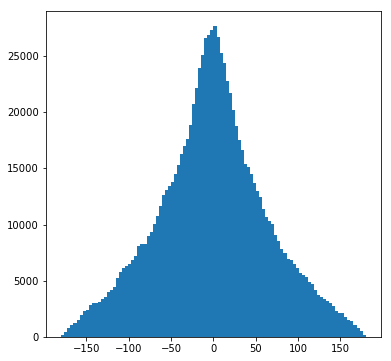

In [9]:
rel_angle = np.abs(df_total['angle_f1']) - np.abs(df_total['angle_f0'])
fix, ax = plt.subplots(figsize=(6,6))
_ = ax.hist(np.rad2deg(rel_angle), bins=100)

In [10]:
df_total[['x_f0', 'y_f0', 'x_f1', 'y_f1', 'angle_f0']][0:1]

,x_f0,y_f0,x_f1,y_f1,angle_f0
0,11.3642,11.2586,18.7658,19.906,-2.64618


14.0795403061 16.3320342857


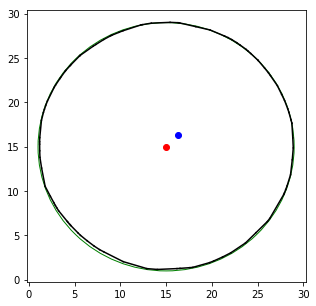

In [11]:
# Estimating the radius/position of the walls
from scipy.spatial import ConvexHull
points =  np.vstack((np.vstack((df.x_f0, df.y_f0)).T, np.vstack((df.x_f1, df.y_f1)).T))
hull = ConvexHull(points)
fig, ax = plt.subplots(figsize=(5,5))
for simplex in hull.simplices:
    ax.plot(points[simplex, 0], points[simplex, 1], 'k-')
cx = np.mean(hull.points[hull.vertices,0])
cy = np.mean(hull.points[hull.vertices,1])
print(cx, cy)
ax.scatter(cy, cy, c='b')
ax.scatter(15, 15, c='red')

circle = plt.Circle((15, 15), 14, color='g', fill=False, clip_on=False)
ax.add_artist(circle)

# Speed and Acceleration

We smooth the speed series with a savgol-filter.
This assumes that all data points are equidistant -> this needs to be fixed!

In [12]:
def smooth(x):    
    # TODO: Use proper values
    degree = 3
    time_window = 18 # change to be 0.36s window
    bandwidth = 4 # change to be 0.08s
    
    x = signal.savgol_filter(x, window_length=49, polyorder=degree, deriv=0) # TODO: Check
    x_deriv = signal.savgol_filter(x, window_length=49, polyorder=degree, deriv=1)
    
    return x, x_deriv

0.00758036007571 0.00398891042878
[ 2.71202288  2.7083393   2.69424715 ...,  0.72009547  0.52926458
  0.31429644]


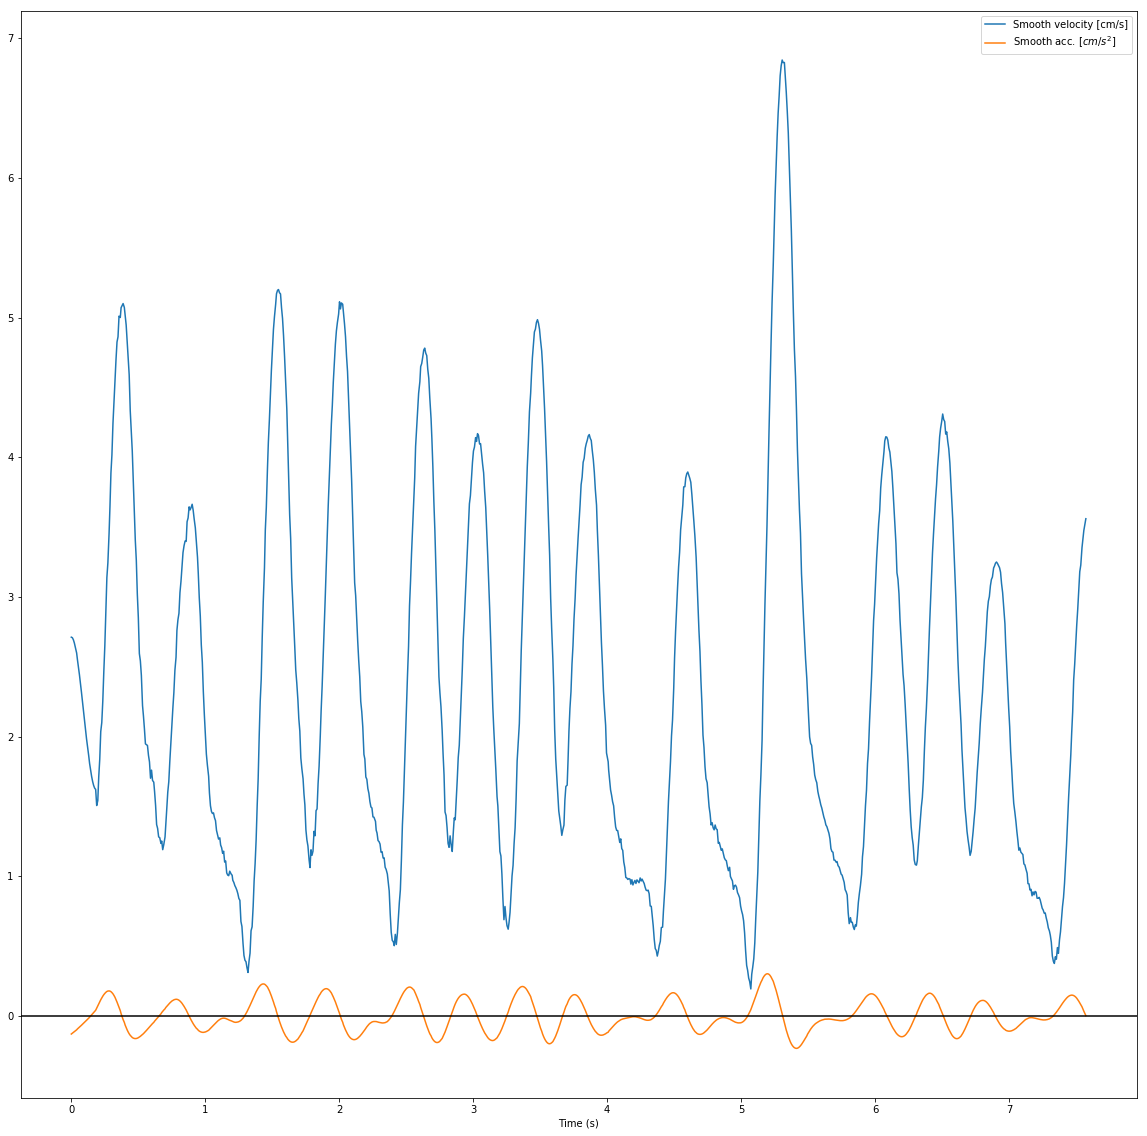

In [13]:
vel0 = df['speed_f0'].values
vel1 = df['speed_f1'].values

vel0_smooth, acc0_smooth = smooth(vel0)
vel1_smooth, acc1_smooth = smooth(vel1)

vel_smooth_x = [None, None]
vel_smooth_y = [None, None]
for f in (0, 1):
    vel_smooth_x[f], _ = smooth(df[f'vX_f{f}'].values)
    vel_smooth_y[f], _ = smooth(df[f'vY_f{f}'].values)


#acc0_smooth = (np.gradient(vel0_smooth))
time = df['time'].values[:]
time_diff = np.ediff1d(time)
print(np.mean(time_diff), np.std(time_diff))
print(vel0_smooth)

till = 1000
fig, ax = plt.subplots(figsize=(20,20))
ax.plot(time[:till], vel0_smooth[:till], label="Smooth velocity [cm/s]")
ax.plot(time[:till], acc0_smooth[:till], label="Smooth acc. [$cm/s^2$]")
ax.set_xlabel("Time (s)")
ax.set_ylabel("")
ax.legend()
ax.axhline(0, color='black', )

## Select activity

Find out, whether the fish are currently swimming, pausing (for a short time) or stopped (for a long time).

In [14]:
SWIMMING = 0
PAUSING = 1
STOPPING = 2

@jit(nopython=True)
def get_status(vel0, vel1, time, treshold):
    time_window = 4.0
    vel_max = np.maximum(vel0, vel1)
    
    time_paused = np.zeros(vel_max.shape)
    
    # Forward pass: Find out how long fish have been pausing
    cur_time_paused = 0
    for i in range(0, len(vel_max)):
        if vel_max[i] >= treshold:
            # Swimming
            cur_time_paused = 0
        else:
            # Pausing or stopping
            if i > 0:
                cur_time_paused += time[i] - time[i - 1]
            else:
                cur_time_paused += time[i]
            #print(cur_time_paused, time[i])
        time_paused[i] = cur_time_paused
        
    # Backwards pass: Set status flags
    status = np.zeros(vel_max.shape)
    is_cur_stopped = False
    for i in range(len(vel_max) - 1, -1, -1):
            if time_paused[i] == 0:
                # Swimming
                is_cur_stopped = False
                status[i] = SWIMMING
            elif is_cur_stopped:
                # Still stopping
                status[i] = STOPPING
            elif time_paused[i] >= treshold:
                # Paused for too long -> Stopping
                is_cur_stopped = True
                status[i] = STOPPING
            else:
                status[i] = PAUSING                    
                    
    return time_paused, status

In [15]:
body_length = 0.64 # cm
threshold = 0.5/body_length
print(f"threshold is {threshold}!")
#print(time[:100])
td, s = get_status(vel0_smooth[0:], vel1_smooth[0:], time[0:], threshold)

threshold is 0.78125!


In [16]:
print(s)
print(s.shape, np.mean(s), np.max(s))
for i in range(0,3):
    print(i, len(np.where(s == i)[0]))

[ 0.  0.  0. ...,  0.  0.  0.]
(958966,) 0.00413153333903 1.0
0 955004
1 3962
2 0


In [17]:
td[0:100], s[:100]

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  

## Segmentation
Find phases where the fish are accelerating and decelerating.

**TODO**: Need to fuse shorter phases together here for noise reduction.

In [18]:
# Find acc phases
ACCELERATING = 1
GLIDING = -1

@jit(nopython=True)
def segmentation(acc, time):
    phases = (acc > 0.0) * ACCELERATING
    # TODO (maybe): fuse nearby accelerating events
    
    events = []
    
    # (idx_start, idx_end, duration, type)    
    idx_start, idx_end, duration, etype = (0, -1, -1, -1)
    cur_sign = -1 * np.sign(acc[0]) # start with correct event
        
    for i, a in enumerate(acc):
        if np.sign(a) != cur_sign or i == (len(acc) -1):        
            # push old event
            idx_end = i - 1
            duration = time[i - 1] - time[idx_start]
            events.append((idx_start, idx_end, duration, cur_sign))
            
            # start new event
            cur_sign *= -1
            idx_start = i                
        
    return events[1:] # skip first invalid element start = end = 0   

In [19]:
phases = segmentation(acc0_smooth, time)
#phases[0:100], acc0[0:100]
len(phases), len(phases), acc0_smooth[0:3]

(32703, 32703, array([-0.12873145, -0.12295835, -0.11707085]))

In [20]:
# Avg. len of a kick
len(acc0_smooth)/32703 * np.mean(time_diff) * 2

0.4445651824211892

In [21]:
phases[0:30]

[(0, 18, 0.13661800000000002, -1.0),
 (19, 49, 0.22739399999999999, 1.0),
 (50, 86, 0.272807, -1.0),
 (87, 115, 0.2117840000000002, 1.0),
 (116, 170, 0.4093530000000001, -1.0),
 (171, 203, 0.24274000000000018, 1.0),
 (204, 234, 0.22844999999999982, -1.0),
 (235, 264, 0.22043999999999975, 1.0),
 (265, 315, 0.37917000000000023, -1.0),
 (316, 346, 0.22727999999999993, 1.0),
 (347, 373, 0.19703000000000026, -1.0),
 (374, 399, 0.18843000000000032, 1.0),
 (400, 428, 0.21255999999999986, -1.0),
 (429, 458, 0.21989000000000036, 1.0),
 (459, 483, 0.18167000000000044, -1.0),
 (484, 508, 0.18216999999999972, 1.0),
 (509, 574, 0.4927100000000002, -1.0),
 (575, 606, 0.23512000000000022, 1.0),
 (607, 665, 0.43942999999999977, -1.0),
 (666, 700, 0.2577000000000007, 1.0),
 (701, 768, 0.5082500000000003, -1.0),
 (769, 803, 0.2576200000000002, 1.0),
 (804, 831, 0.2047099999999995, -1.0),
 (832, 858, 0.19571000000000005, 1.0),
 (859, 885, 0.19701000000000057, -1.0),
 (886, 909, 0.1737700000000011, 1.0),


In [22]:
for p in phases:
    _, _, d, _ = p
    if d == 0:
        print(p)
time[954404], time[954405]

(60685, 60685, 0.0, 1.0)
(109602, 109602, 0.0, -1.0)
(179210, 179210, 0.0, -1.0)
(183795, 183795, 0.0, 1.0)
(188840, 188840, 0.0, 1.0)
(209048, 209048, 0.0, 1.0)
(237396, 237396, 0.0, 1.0)
(241697, 241697, 0.0, 1.0)
(313617, 313617, 0.0, 1.0)
(343028, 343029, 0.0, 1.0)
(358948, 358948, 0.0, 1.0)
(370183, 370184, 0.0, 1.0)
(388658, 388658, 0.0, -1.0)
(405220, 405220, 0.0, -1.0)
(417108, 417108, 0.0, 1.0)
(430140, 430141, 0.0, -1.0)
(442450, 442450, 0.0, 1.0)
(451692, 451692, 0.0, 1.0)
(456475, 456475, 0.0, 1.0)
(462818, 462818, 0.0, -1.0)
(474130, 474130, 0.0, -1.0)
(506035, 506035, 0.0, -1.0)
(523637, 523637, 0.0, 1.0)
(547275, 547275, 0.0, 1.0)
(557190, 557190, 0.0, 1.0)
(593107, 593107, 0.0, 1.0)
(667255, 667256, 0.0, 1.0)
(668805, 668806, 0.0, -1.0)
(689076, 689077, 0.0, -1.0)
(709730, 709731, 0.0, 1.0)
(758514, 758514, 0.0, 1.0)
(758515, 758515, 0.0, -1.0)
(803510, 803510, 0.0, 1.0)
(849375, 849375, 0.0, 1.0)
(849376, 849376, 0.0, -1.0)
(883298, 883298, 0.0, 1.0)
(892785, 892786, 0

(7234.7299999999996, 7234.7299999999996)

## Angle between fish
We need to find the angle between both fishs.

This part is still a bit dubious. 

In [113]:
# angle_between from https://stackoverflow.com/a/13849249
@jit
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

@jit
def angle_between(v1, v2, signed=True):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    if signed:
        return np.arctan2(np.cross(v1_u, v2_u), np.dot(v1_u, v2_u))
    else:
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
@jit  
def angled_vector(angle, reference=np.array([1, 0])):
    """ Calculate a unit vector of angle 'angle' w.r.t the vector 'reference'. """
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([c, -s, s, -c]).reshape(2,2)
    return (R @ reference.reshape(2,1)).reshape(2)

@jit
def sub_angles(a, b):
    """Subtract two angles whilst clipping them into a reasonable range."""
    return (a - b + np.pi + 2*np.pi) % (2 * np.pi) - np.pi

@jit
def get_wall_influence(orientation, point, center, radius):
    clostest_point = center + radius * unit_vector(point - center)
    distance = np.linalg.norm(clostest_point - point)
    wall_angle = angle_between(np.array([-1,0]), clostest_point - point)
    # Orientation is calculated w.r.t. to [1, 0] from tracking, possible bug.
    relative_angle = sub_angles(wall_angle, -orientation)
    return clostest_point, distance, relative_angle

In [24]:
angles_tracking = []
angles_vel = []
angles_vel_smooth = []
angles_pos = []

def get_heading(angle, vXY, vXY_smooth, xy_start, xy_end):
    x_axis = np.array([1,0])
    angle_vel = angle_between(x_axis, vXY)
    angle_vel_smooth = angle_between(x_axis, vXY_smooth)
    angle_dx = angle_between(x_axis, xy_end - xy_start)
    return np.round(np.rad2deg(np.array([angle, angle_vel, angle_vel_smooth, angle_dx])), decimals=2)

x_axis = np.array([1,0])

t_start = 1
for t in range(t_start, t_start + len(df_total['angle_f0']) - 2):

    # Estimate the angle in three different ways.
    angle = [None, None]
    vXY = [None, None]
    vXY_smooth = [None, None]
    xy_start = [None, None]
    xy_end = [None, None]
    
    for f in [0]:
        angle[f] = df_total[f'angle_f{f}'][t]

        vX = df_total[f'vX_f{f}'][t]
        vY = df_total[f'vY_f{f}'][t]
        vXY[f] = np.array([vX, vY])

        vXY_smooth[f] = np.array([vel_smooth_x[f][t], vel_smooth_y[f][t]])

        x_start = df_total[f'x_f{f}'][t]
        y_start = df_total[f'y_f{f}'][t]
        xy_start[f] = np.array([x_start, y_start])

        x_end = df_total[f'x_f{f}'][t+1]
        y_end = df_total[f'y_f{f}'][t+1]
        xy_end[f] = np.array([x_end, y_end])        
        
        angle_tracking, angle_vel, angle_vel_smooth, angle_pos  = \
            tuple(get_heading(angle[f], vXY[f], vXY_smooth[f], xy_start[f], xy_end[f]))
        #print(get_heading(angle[f], vXY[f], vXY_smooth[f], xy_start[f], xy_end[f]))
    
    #relative_angles = np.array([angle[1]-angle[0], angle_between(vXY[0], vXY[1]), 
    #                           angle_between(vXY_smooth[0], vXY_smooth[1]),
    #                           angle_between(xy_end[0] - xy_start[0], xy_end[1] - xy_start[1])])
    angles_tracking.append(angle_tracking)
    angles_vel.append(angle_vel)
    angles_vel_smooth.append(angle_vel_smooth)
    angles_pos.append(angle_pos)
   # print(np.round(np.rad2deg(relative_angles), decimals=2))
  #  print()
angles_tracking = np.array(angles_tracking)
angles_vel = np.array(angles_vel)
angles_vel_smooth = np.array(angles_vel_smooth)
angles_pos = np.array(angles_pos)

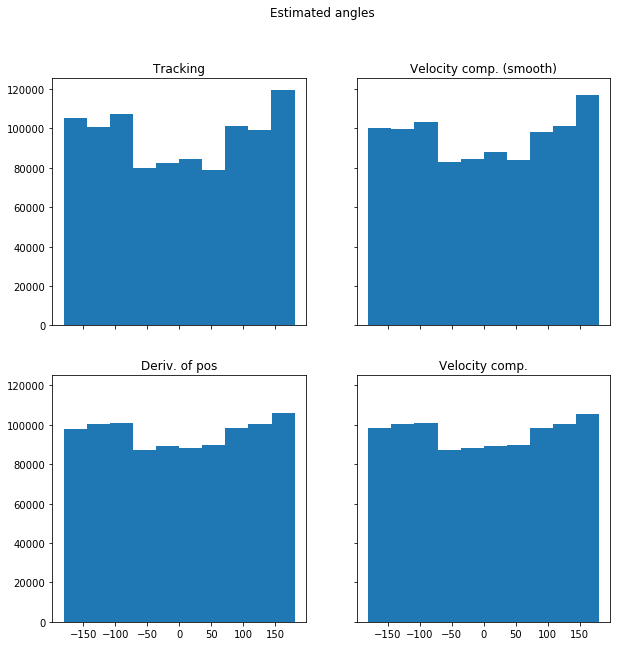

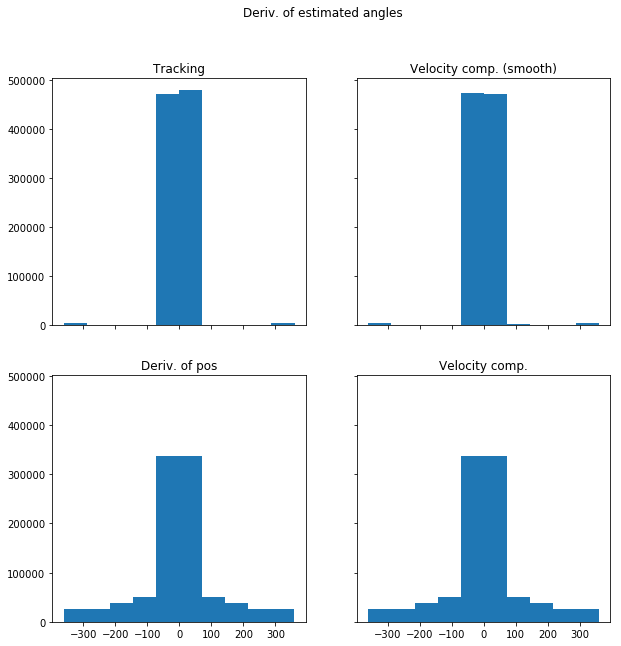

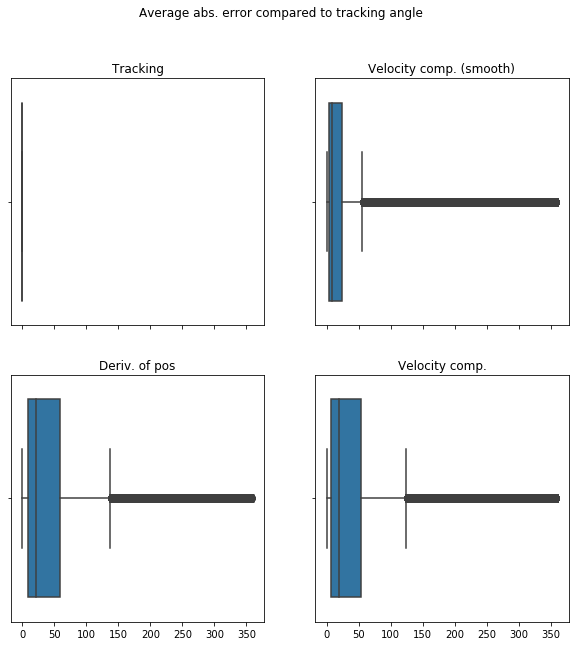

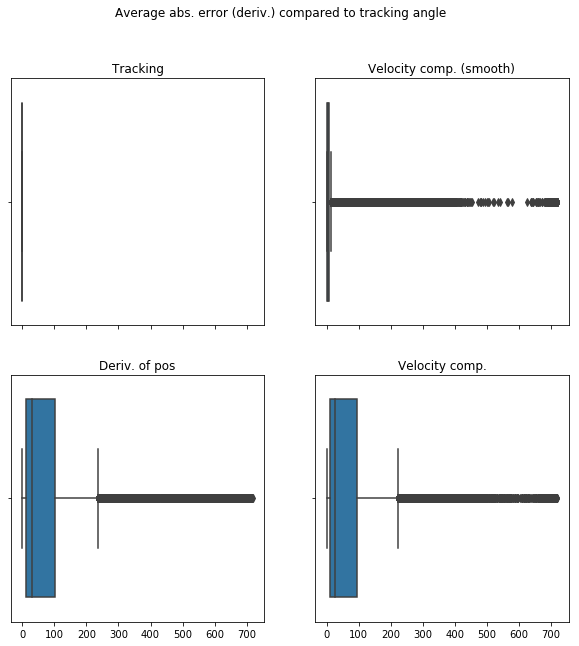

In [25]:
fig, ax = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax[0,0].hist(angles_tracking)
ax[0,0].set_title("Tracking")
ax[0,1].hist(angles_vel_smooth)
ax[0,1].set_title("Velocity comp. (smooth)")
ax[1,0].hist(angles_pos[~np.isnan(angles_pos)])
ax[1,0].set_title("Deriv. of pos")
ax[1,1].hist(angles_vel)
ax[1,1].set_title("Velocity comp.")
fig.suptitle("Estimated angles")

fig, ax = plt.subplots(2,2, figsize=(10,10), sharex=True, sharey=True)
ax[0,0].hist(np.ediff1d(angles_tracking))
ax[0,0].set_title("Tracking")
ax[0,1].hist(np.ediff1d(angles_vel_smooth))
ax[0,1].set_title("Velocity comp. (smooth)")
ax[1,0].hist(np.ediff1d(angles_pos[~np.isnan(angles_pos)]))
ax[1,0].set_title("Deriv. of pos")
ax[1,1].hist(np.ediff1d(angles_vel))
ax[1,1].set_title("Velocity comp.")
fig.suptitle("Deriv. of estimated angles")

fig, ax = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)
sns.boxplot(x= np.abs(angles_tracking - angles_tracking), ax=ax[0,0])
ax[0,0].set_title("Tracking")
sns.boxplot(x= np.abs(angles_tracking - angles_vel_smooth), ax=ax[0,1])
ax[0,1].set_title("Velocity comp. (smooth)")
sns.boxplot(x= np.abs(angles_tracking[~np.isnan(angles_pos)] - angles_pos[~np.isnan(angles_pos)]), ax=ax[1,0])
ax[1,0].set_title("Deriv. of pos")
sns.boxplot(x= np.abs(angles_tracking - angles_vel), ax=ax[1,1])
ax[1,1].set_title("Velocity comp.")
fig.suptitle("Average abs. error compared to tracking angle")

fig, ax = plt.subplots(2,2, figsize=(10, 10), sharex=True, sharey=True)
sns.boxplot(x= np.abs(np.ediff1d(angles_tracking) - np.ediff1d(angles_tracking)), ax=ax[0,0])
ax[0,0].set_title("Tracking")
sns.boxplot(x= np.abs(np.ediff1d(angles_tracking) - np.ediff1d(angles_vel_smooth)), ax=ax[0,1])
ax[0,1].set_title("Velocity comp. (smooth)")
sns.boxplot(x= np.abs(np.ediff1d(angles_tracking[~np.isnan(angles_pos)]) - np.ediff1d(angles_pos[~np.isnan(angles_pos)])), ax=ax[1,0])
ax[1,0].set_title("Deriv. of pos")
sns.boxplot(x= np.abs(np.ediff1d(angles_tracking) - np.ediff1d(angles_vel)), ax=ax[1,1])
ax[1,1].set_title("Velocity comp.")
fig.suptitle("Average abs. error (deriv.) compared to tracking angle")

(129.80844152851157, 156.41480306133977)

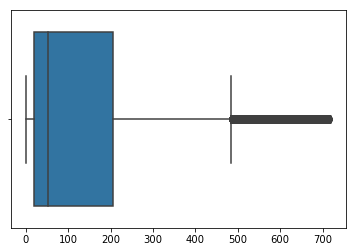

In [26]:
t = np.abs(np.ediff1d(angles_vel[~np.isnan(angles_pos)]) - np.ediff1d(angles_pos[~np.isnan(angles_pos)]))
sns.boxplot(t)
np.mean(t), np.std(t)

In [201]:
def summarise_kick(phase, pos, border_distance):
    start = phase[0][0]
    end = phase[1][1]
    duration = phase[0][2] + phase[1][2]
    
    pos_start = np.array([ pos[0][start], pos[1][start] ])
    pos_end = np.array([ pos[0][end], pos[1][end] ])

    traj_kick = pos_end - pos_start
    heading = unit_vector(traj_kick)
    kick_len = np.linalg.norm(traj_kick)
   
    return start, end, duration, heading, kick_len, border_distance

def summarise_kicks(pos, acc, border_distance, time):
    phases = segmentation(acc, time)
    # If heading is zero (no current kick) need to estimate traj. differently!
    
    # Find first acceleration phase
    begin = 0
    for i in range(0, len(phases)):
        if phases[i][-1] == 1:
            begin = i
            break
    print(f"Begin={begin}")    
    
    kicks = []
    for i in range(begin, len(phases)//2):
        # A phase consists in a acceleration + gliding phase
        phase = phases[i*2 : i*2+2]
        kicks.append(summarise_kick(phase, pos, border_distance))
        
    # Convert back to frame information (needed for angle calc!)    
    # Some headings are zero. This'll lead to problems later!
    headings = np.zeros( (len(acc), 2) )
    for k in kicks:
        start, end, _, heading, _, _ = k
        headings[start:end] = heading
        
    return kicks, headings

def calc_angles(kick, pos_0, pos_1, angles_0, angles_1, vel_0, wall_fun, fish_mapping, verbose=False):
    x_axis = np.array([1, 0]) # Used as a common reference for angles.
    
    start, end, duration, heading, kick_len, _ = kick
    
    pos_f0 = np.array([ pos_0[0][start], pos_0[1][start] ])
    pos_f1 = np.array([ pos_1[0][start], pos_1[1][start] ])
 
    # Traj. vector of both fish
    # We use the angle of the fish, as it is more stable than the velocity.
    traj_f0 = angled_vector(angles_0[start])
    traj_f1 = angled_vector(angles_1[start])
  
    # Vector connecting both fish, note that it is directed!
    dist = pos_f1 - pos_f0
    dist_angle = angle_between(x_axis, dist)

    # Calculate relevant angles and focal fish
    viewing_angle_0t1 = sub_angles(dist_angle, angles_0[start])
    viewing_angle_1t0 = sub_angles(-dist_angle, angles_1[start])
    
    # The focal fish is defined as the geometric leader, i.e. the fish with the larger viewing angle.
    # Corresponds to the fish which would need to turn more to look directly at the other fish.
    # The sign of the relative orientation depends on which fish is the focal one.
    if np.abs(viewing_angle_0t1) > np.abs(viewing_angle_1t0):
        geometric_leader = fish_mapping[0]
        rel_orientation = sub_angles(angles_1[start], angles_0[start])
        viewing_angle_leader, viewing_angle_follower = viewing_angle_0t1, viewing_angle_1t0
    else:
        geometric_leader = fish_mapping[1]
        rel_orientation = sub_angles(angles_0[start], angles_1[start])
        viewing_angle_leader, viewing_angle_follower = viewing_angle_1t0, viewing_angle_0t1
                         
    # Collect some other summary data about the kick
    traj_kick = np.array([ pos_0[0][end], pos_0[1][end] ]) - pos_f0
    
    # Wall distance and angle
    #def get_wall_influence(orientation, point, center, radius):
    clostest_point_0, wall_distance_0, wall_angle_0 = wall_fun(angles_0[start], pos_f0)
    clostest_point_1, wall_distance_1, wall_angle_1 = wall_fun(angles_1[start], pos_f1)

    if verbose:
        print(f"Max swimming velocity {np.max(vel_0[start:end])}")
        print("Start = {}, end {}, duration = {}".format(start, end, duration))
        print("Trajectories: f0 = {}, f1 = {}".format(unit_vector(traj_f0), unit_vector(traj_f1)))
        print("x/y: f0 = {}, f1 = {}".format(pos_f0, pos_f1))
        print("Distance = {}, norm = {}, data = {}".format(dist, np.linalg.norm(dist), df_total['neighbor_distance'][start]))

        print("Viewing angles: 0->1 = {:3.2f}°, 1->0 = {:3.2f}°".format(
            np.rad2deg(viewing_angle_0t1), np.rad2deg(viewing_angle_1t0)))
        print("Geometric leader is {}.".format(geometric_leader))
        print("Relative orientation = {:3.2f}°".format(np.rad2deg(rel_orientation)))
        print("Heading = {}, kick_len = {}".format(unit_vector(traj_kick), np.linalg.norm(traj_kick)))
        
        print(f"Wall distance: 0 = {wall_distance_0}, 1 = {wall_distance_1}")
        print(f"Wall angle: 0 = {np.rad2deg(wall_angle_0)}, 1 = {np.rad2deg(wall_angle_1)}")
   
    return dist, geometric_leader, viewing_angle_leader, viewing_angle_follower,\
        rel_orientation,\
        wall_distance_0, wall_angle_0, wall_distance_1, wall_angle_1

In [206]:
wall_fun = lambda orientation, point: get_wall_influence(orientation, point, np.array([15,15]), 14)
for i in range(0,5):
    calc_angles(kicks_0[i], pos_0, pos_1, df_total['angle_f0'], df_total['angle_f1'], vel0_smooth, wall_fun, fish_mapping=('f0', 'f1'), verbose=True)
    print("\n")

Max swimming velocity 5.100099971954389
Start = 50, end 115, duration = 0.4845910000000002
Trajectories: f0 = [-0.93844946 -0.34541658], f1 = [-0.89369029  0.44868436]
x/y: f0 = [ 10.4025  10.8446], f1 = [ 17.9994  20.2538]
Distance = [ 7.5969  9.4092], norm = 12.093218523205476, data = 12.1299
Viewing angles: 0->1 = -149.12°, 1->0 = 155.58°
Geometric leader is f1.
Relative orientation = 46.87°
Heading = [-0.99470967 -0.10272618], kick_len = 1.2051456148117534
Wall distance: 0 = 7.80287523039918, 1 = 7.950304569649809
Wall angle: 0 = -117.68426627539027, 1 = 33.61860288179312


Max swimming velocity 5.170021175216116
Start = 116, end 203, duration = 0.6520930000000003
Trajectories: f0 = [-0.99997693  0.0067926 ], f1 = [-0.7994167   0.60077695]
x/y: f0 = [  9.16939  10.7198 ], f1 = [ 17.0193  21.2335]
Distance = [  7.84991  10.5137 ], norm = 13.120936502327112, data = 13.1238
Viewing angles: 0->1 = -126.36°, 1->0 = 163.67°
Geometric leader is f1.
Relative orientation = 36.54°
Heading = 

array([ 2.71202278,  2.70833921,  2.69424725, ...,  0.72009546,
        0.52926457,  0.31429642], dtype=float32)

In [106]:
pos_0 = (df_total['x_f0'], df_total['y_f0'])
pos_1 = (df_total['x_f1'], df_total['y_f1'])
border_distance_0 =  df_total['border_distance_f0']
border_distance_1 =  df_total['border_distance_f1']
kicks_0, headings_0 = summarise_kicks(pos_0, acc0_smooth, border_distance_0, time)
kicks_1, headings_1 = summarise_kicks(pos_1, acc1_smooth, border_distance_1, time)
print(np.mean(headings_0, axis=0), np.mean(headings_1, axis=0))

kicks_0_df = pd.DataFrame(kicks_0)
kicks_1_df = pd.DataFrame(kicks_1)
columns =  ['start', 'end', 'duration', 'heading', 'kick_len', 'wall_distance']
kicks_0_df.columns = columns
kicks_1_df.columns = columns
kicks_0_df.describe()

Begin=1
Begin=0
[-0.07964167  0.00630582] [-0.06177962  0.0299267 ]


,start,end,duration,kick_len
count,16350.000000,16350.000000,16350.000000,16350.000000
mean,482818.431498,482876.080000,0.429450,0.698663
std,277522.302514,277521.595309,0.142401,0.449059
min,50.000000,115.000000,0.010000,0.000714
25%,242188.750000,242228.750000,0.330000,0.340791
50%,487035.500000,487090.500000,0.400000,0.625351
75%,723153.250000,723205.000000,0.500000,1.002710
max,958882.000000,958952.000000,1.450000,4.442665


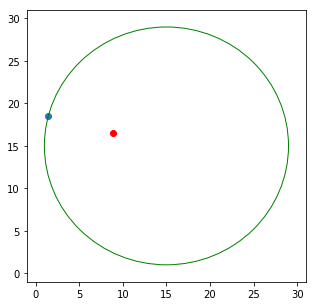

In [31]:
start, end, duration, heading, kick_len, _ = kicks_0[3000]
pos = np.array([df_total['x_f0'][start], df_total['y_f0'][start]])
closest_point, distance, angle = get_wall_influence(df_total['angle_f0'][start], pos, np.array([15,15]), 14)
print(closest_point, distance, np.rad2deg(angle))

# Verify that we actually find the closest point on the circle!
fig, ax = plt.subplots(figsize=(5,5))
#ax.scatter(cy, cy, c='b')
ax.scatter(pos[0], pos[1], c='red')
ax.scatter(closest_point[0], closest_point[1])

circle = plt.Circle((15, 15), 14, color='g', fill=False, clip_on=True)
ax.set_xbound(-1, 31)
ax.set_ybound(-1, 31)
ax.add_artist(circle)

0.103081608523


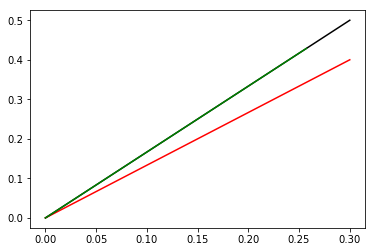

In [32]:
a = np.array([0.3, 0.4])
b = np.array([0.3, 0.5])
theta = angle_between(a,b)
print(theta)
c, s = np.cos(theta), np.sin(theta)
R = np.matrix('{} {}; {} {}'.format(c, -s, s, c))
plt.plot([0, 0.3], [0, 0.4], c='red')
plt.plot([0, 0.3], [0, 0.5], c='black')
b2 = R * a.reshape(2,1)
plt.plot([0, b2[0]], [0, b2[1]], c='green')

In [33]:
angles_0 = []
angles_1 = []
for kick in kicks_0:
    angles_0.append(calc_angles(kick, pos_0, pos_1, df_total['angle_f0'], df_total['angle_f1'], fish_mapping=('f0', 'f1'), verbose=False))
for kick in kicks_1:
    angles_1.append(calc_angles(kick, pos_1, pos_0, df_total['angle_f1'], df_total['angle_f0'], fish_mapping=('f1', 'f0'), verbose=False))

In [35]:
leader_0 = 0
leader_1 = 0
nan_count = 0
rel_orientation_l = []
rel_orientation_avg = 0.0
for (dist, geometric_leader, viewing_angle_0t1, viewing_angle_1t0, rel_orientation) in (angles_0 + angles_1):
    if rel_orientation != rel_orientation:
        #print(f"nan! dist={dist}, 0->1={viewing_angle_0t1}, 1->0={viewing_angle_1t0}")
        nan_count += 1
        continue
    rel_orientation_avg += rel_orientation
    rel_orientation_l.append(rel_orientation)
    if geometric_leader == 'f0':
        leader_0 += 1
    else:
        leader_1 += 1
rel_orientation_avg = np.rad2deg(rel_orientation_avg/(len(angles_0)))
rel_orientation_l = np.array(rel_orientation_l)
print(leader_0, leader_1)
print(f"Rel. orientation {rel_orientation_avg}")
print(f"Found {nan_count} NaNs")

15878 17823
Rel. orientation 19.47084167091849
Found 0 NaNs


In [36]:
np.mean(np.rad2deg(np.abs(rel_orientation_l)))

70.209196600086258

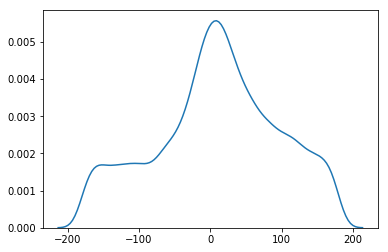

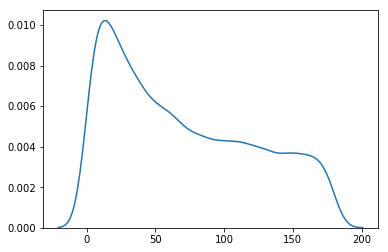

In [37]:
fig, ax = plt.subplots()
#ax.hist(np.rad2deg(rel_orientation_l))
sns.kdeplot(np.rad2deg(rel_orientation_l))
plt.figure()
sns.kdeplot(np.abs(np.rad2deg(rel_orientation_l)))

In [38]:
# Calculate the average heading difference between both fish
# Right now I'm using the x-axis as a reference point, shouldn't matter in practice though
relative_headings = []
viewing_angle_follower = []
viewing_angle_leader = []
for i in range(len(angles_0)):
    # start, end, duration, heading, kick_len, border_distance
    
    start = kicks_0[i][0]
    h0, h1 = headings_0[start], headings_1[start]
    #h0, h1 = kicks_0[i][3], kicks_1[i][3]
    
    # choice of kicks doesn't matter
    leader = angles_0[i][1]
    x_axis = np.array([1.0, 0.0])
    a0 = (angle_between(x_axis, h0))
    a1 = (angle_between(x_axis, h1))
    if leader == 'f0':
        relative_headings.append(a1-a0)
    else:
        relative_headings.append(a0-a1)
    viewing_angle_follower.append(angles_0[i][3])
    viewing_angle_leader.append(angles_0[i][4])
    
relative_headings = np.array(relative_headings)
viewing_angle_follower = np.array(viewing_angle_follower)
viewing_angle_leader = np.array(viewing_angle_leader)

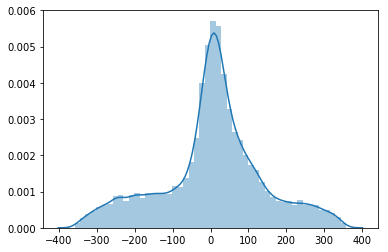

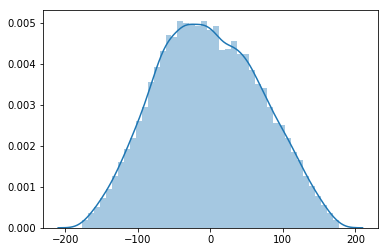

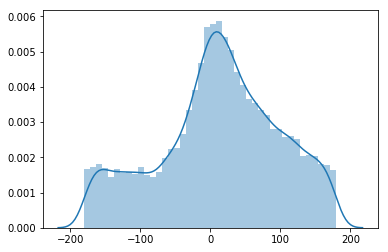

In [39]:
sns.distplot(np.rad2deg(relative_headings[~np.isnan(relative_headings)]))
plt.figure()
sns.distplot(np.rad2deg(viewing_angle_follower[~np.isnan(viewing_angle_follower)]))
plt.figure()
sns.distplot(np.rad2deg(viewing_angle_leader[~np.isnan(viewing_angle_leader)]))

In [91]:
# Avg. heading change for fish 0
def plot_avg_heading(ignore_wall=False):
    hsn = []
    for i in range(1, len(kicks_0_df)):
        if True:
            #a = angle_between(kicks_0_df['heading'][i], kicks_0_df['heading'][i - 1])
            a = sub_angles(df_total['angle_f0'][kicks_0_df['start'][i]], df_total['angle_f0'][kicks_0_df['start'][i - 1]])
            hsn.append(a)
    hs = np.array(hsn)
    sns.kdeplot(np.rad2deg(hs[~np.isnan(hs)]))
    plt.figure()
    sns.kdeplot(np.abs(np.rad2deg(hs[~np.isnan(hs)])))
    plt.xlim(0, 120)
    print(np.mean(np.rad2deg(hs[~np.isnan(hs)])), np.std(np.rad2deg(hs[~np.isnan(hs)])))

-3.2706479659 34.9635436727


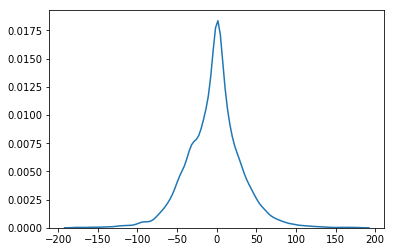

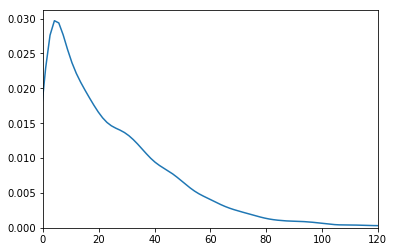

In [92]:
plot_avg_heading(False)

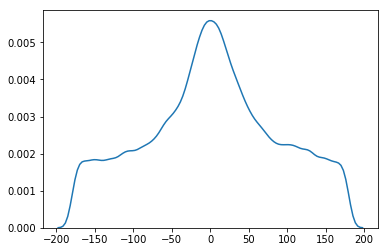

In [102]:
sns.kdeplot((np.rad2deg(sub_angles(df['angle_f0'],df['angle_f1']))), clip=(-180, 180))